In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl

import os
import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord, Angle, Galactic, ICRS
from astropy import units as u
from astropy.table import Table

from shapely.geometry import Polygon

from piaa.utils import get_fov_plot
from piaa.observation import Observation

from pocs.utils.database import PanMongo

plt.style.use('bmh')
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 20, 15
%matplotlib inline

In [2]:
db = PanMongo()
collection = db._client.panoptes.fits_headers

### Get Targets by Field

Observational data is stored in a mongodb collection so we aggregate the data here

In [3]:
sequences = collection.aggregate([
    {
        '$match': { 'CREATOR': 'POCSv0.1.1' }
    },
    {
        '$group': {
            '_id': '$SEQID',
            'exp_time': {'$sum': '$EXPTIME'},
            'num_exp': {'$sum': 1},
            'date_obs': {'$first': '$DATE-OBS'},
            'field': {'$first': '$FIELD'},
            'ra': {'$first': '$RA-MNT'},
            'dec': {'$first': '$DEC-MNT'},                        
        },
    }
])

### Build Tables

In [4]:
obs_table = pd.DataFrame([seq for seq in sequences]).set_index(['field','_id'])
obs_table.sort_index(axis=0, inplace=True)
obs_table['date_obs'] = pd.to_datetime(obs_table['date_obs'])
obs_table.sort_index(axis=1, inplace=True)

In [5]:
# Generate Latex file
stats_table = pd.DataFrame({
    'exp_times': obs_table['exp_time'].sum(level='field'),
    'num_exp': obs_table['num_exp'].sum(level='field')
}).sort_values('num_exp')

with open('target_coverage.tex', 'w') as f:
    f.write(stats_table.to_latex())

In [6]:
total_time = stats_table['exp_times'].sum() * u.second

first_date = obs_table['date_obs'].min()
last_date = obs_table['date_obs'].max()
num_nights = len(set(["{}".format(date.date()) for date in obs_table['date_obs']]))

### Plot

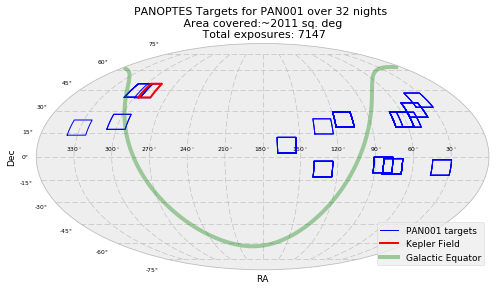

In [9]:
# Polygons for FOV
polys = []

# Offset the Mollweide projection
org = 180 * u.degree


fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111, projection="mollweide")
ax.tick_params(labelsize=6)

# FOV for each field
for idx in range(len(obs_table)):
    x, y, poly = get_fov_plot(coords=(obs_table['ra'][idx] * u.deg, obs_table['dec'][idx] * u.deg), 
                                  org=org, return_polygon=True)    
    polys.append(poly)

    if idx == 0:
        ax.plot(x, y, c='blue', lw=1, label='PAN001 targets')
    else:
        ax.plot(x, y, c='blue', lw=1)

# Add the Kepler Field
x, y = get_fov_plot(coords=(290.45 * u.degree, 44.4 * u.degree), width=11.5, height=10, org=org)
ax.plot(x, y, c='red', label='Kepler Field')
       
# Show galactic equator - http://balbuceosastropy.blogspot.com.au/2013/09/the-mollweide-projection.html
eq_ra = []
eq_dec = []
for c in Galactic(l=np.arange(120, 475) * u.deg, b=0 * u.deg).transform_to(ICRS):
    x = np.remainder(c.ra + (360 * u.degree) - org, (360 * u.degree)) # shift RA values
    ind = x > (180 * u.degree)
    x[ind] -= (360 * u.degree)    # scale conversion to [-180, 180]
    x=-x                          # reverse the scale: East to the left
    eq_ra.append(Angle(x).radian)
    eq_dec.append(Angle(c.dec).radian)
ax.plot(eq_ra, eq_dec, 'g', lw=4, alpha=0.35, label='Galactic Equator')
    
# Make ticks look nice
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210]) * u.degree
tick_labels = np.remainder(tick_labels + (360 * u.degree) + org, 360 * u.degree).value
ax.set_xticklabels(["{:.0f}$^\circ$".format(t) for t in tick_labels])

# Get total area
area1 = Polygon()
for p in polys:
    area1 = area1.union(p)

# Legend, labels, title
ax.legend(loc=4, fontsize=9)
ax.set_ylabel('Dec', fontsize=9)
ax.set_xlabel('RA', fontsize=9)    
    
ax.set_title("PANOPTES Targets for PAN001 over {} nights \n Area covered:" \
             "~{:.0f} sq. deg \n Total exposures: {}".format(
    num_nights, 
    area1.area, 
    obs_table['num_exp'].sum()), fontsize=11)
fig.tight_layout()

fig.savefig('pan001_targets.png', dpi=300)

In [8]:
print("Total exposure time: {:.0f} ({:.02f})".format(total_time, total_time.to(u.hour)))
print("Total num exposures: {}".format(stats_table['num_exp'].sum()))
print("First date:          {}".format(str(first_date)))
print("Last date:           {}".format(str(last_date)))
print("Days observing:      {}".format(str(num_nights)))
print("Total days:          {}".format(str((last_date - first_date).days)))

Total exposure time: 852169 s (236.71 h)
Total num exposures: 7147
First date:          2016-09-09 08:12:26
Last date:           2017-01-31 11:22:42
Days observing:      32
Total days:          144
